# Классификация токсичных комментариев

### В данном проекте проведен анализ реальных комментариев со страниц обсуждений Википедии. К сожалению, некоторые пользователи позволяют себе писать сообщения, содержащие ругательства, угрозы и оскорбления. Автор данного проекта осуждает этих людей и анализирует токсичные комментарии только с целью построения алгоритма, позволяющего отделять их от чистых комментариев.

### Автор данного проекта не имеет никакого отношения к содержанию анализируемых комментариев. Пожалуйста закройте данный проект, если вы не приемлете сообщения, содержащие ругательства, угрозы, оскорбления и прочие негативные формы выражения своих мыслей.

[Соревнование на Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In [1]:
import pandas as pd
import numpy as np

import re
import wordcloud
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Чтение данных

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

In [3]:
train_df.shape, test_df.shape, sample_submission_df.shape

((159571, 8), (153164, 2), (153164, 7))

In [4]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
sample_submission_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


# Классы комментариев

Признак clear означает, что комментарий не относится ни к одному из классов токсичности.

In [9]:
train_df['clear'] = 1 - train_df[train_df.columns[2:]].max(axis=1)

Классы комментариев (все кроме clear - токсичные):

In [10]:
comment_classes = {'toxic': 'Обычные токсичные',
                   'severe_toxic': 'Сильно токсичные',
                   'obscene': 'Непристойные',
                   'threat': 'Содержащие угрозу',
                   'insult': 'Оскорбительные',
                   'identity_hate': 'Содержащие ненависть к личности',
                   'clear': 'Чистые'}

Посмотрим на все toxic комментарии. Больше половины из них относятся также к другим классам токсичности:

In [11]:
print('Количество классов токсичности, к которым также относятся toxic комментарии:')
train_df[train_df['toxic'] == 1].iloc[:, 3:8].sum(axis=1).value_counts()

Количество классов токсичности, к которым также относятся toxic комментарии:


0    5666
2    4189
1    3263
3    1760
4     385
5      31
dtype: int64

Теперь посмотрим на все не toxic комментарии. Очень малая доля из них относится к другим классам токсичности:

In [12]:
print('Количество классов токсичности, к которым также относятся не toxic комментарии:')
train_df[train_df['toxic'] == 0].iloc[:, 3:8].sum(axis=1).value_counts()

Количество классов токсичности, к которым также относятся не toxic комментарии:


0    143346
1       694
2       217
3        20
dtype: int64

Посмотрим, какой процент комментариев обучающей выборки относится к каждому из классов токсичности:

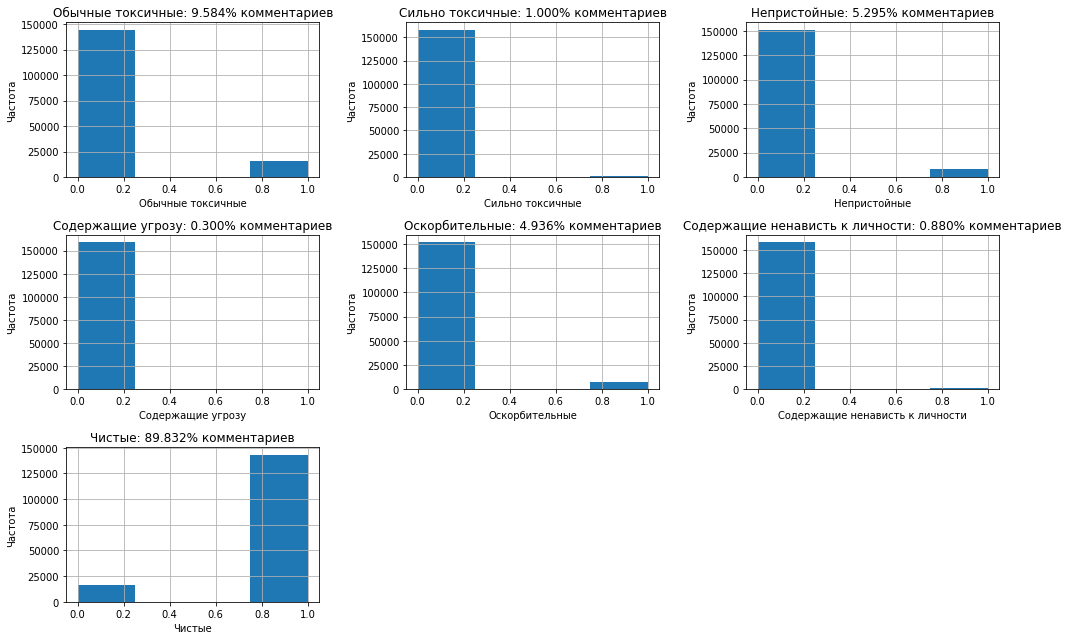

In [13]:
fig = plt.figure(figsize=(15, 9))
for i, tox_type in enumerate(train_df.columns[2:9], start=1):
    ax = fig.add_subplot(3, 3, i)
    train_df[tox_type].hist(ax=ax, bins=4)
    
    value_counts = train_df[tox_type].value_counts()
    percentage = (value_counts[1] / sum(value_counts) * 100)
    title = '{}: {:.3f}% комментариев'.format(comment_classes.get(tox_type), percentage)
    ax.set(title=title, xlabel=comment_classes.get(tox_type), ylabel='Частота')
    
plt.tight_layout()

# Длина комментариев

In [14]:
train_df['comment_length'] = train_df['comment_text'].str.len()
test_df['comment_length'] = test_df['comment_text'].str.len()

In [15]:
train_df['comment_length'].describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

In [16]:
test_df['comment_length'].describe()

count    153164.000000
mean        364.875121
std         592.492099
min           1.000000
25%          79.000000
50%         180.000000
75%         392.000000
max        5000.000000
Name: comment_length, dtype: float64

Посмотрим на распределение длины комментариев в обучающей и тестовой выборках:

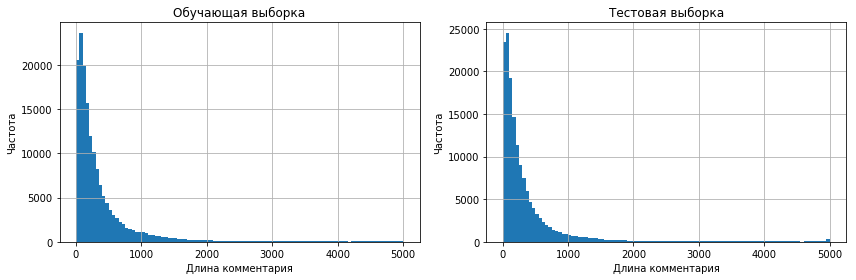

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

titles = ['Обучающая', 'Тестовая']
for i, (df, title) in enumerate(zip([train_df, test_df], titles)):
    df['comment_length'].hist(ax=ax[i], bins=100)
    ax[i].set(title=title + ' выборка', xlabel='Длина комментария', ylabel='Частота')

plt.tight_layout()

### Далее под токсичными подразумеваются комментарии, относящиеся хотя бы к одному из классов токсичности.

Посмотрим на распределение длины токсичных и чистых комментариев в обучающей выборке:

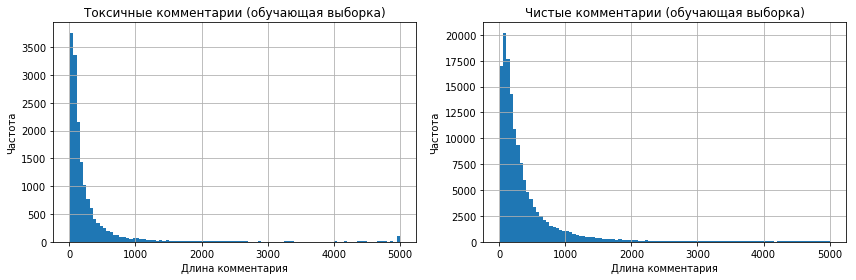

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, title in enumerate(['Токсичные', 'Чистые']):
    train_df[train_df['clear'] == i]['comment_length'].hist(ax=ax[i], bins=100)
    ax[i].set(title=title + ' комментарии (обучающая выборка)',
              xlabel='Длина комментария', ylabel='Частота')

plt.tight_layout()

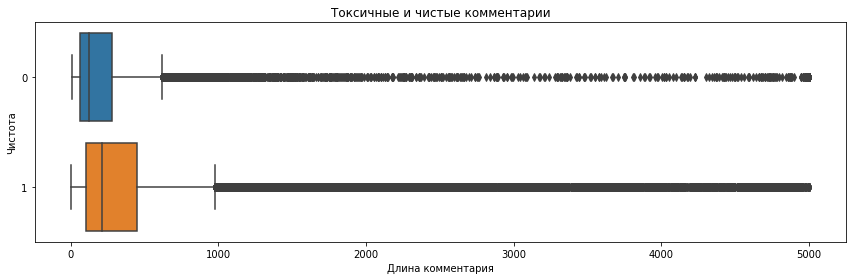

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(y='clear', x='comment_length', orient='h', data=train_df, ax=ax)
ax.set(title='Токсичные и чистые комментарии')
ax.set(xlabel='Длина комментария', ylabel='Чистота')
plt.tight_layout()

Отсутствуют серьезные различия в длине токсичных и чистых комментариев. Построение итоговой модели показало, что использование длины комментариев ухудшает качество.

# Обработка текста комментариев

### Функции обработки

In [20]:
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.probability import FreqDist
from nltk.util import bigrams, ngrams

import re
import string

Добавим к стоп-словам все слова, состоящие из одной буквы.

In [21]:
stop_words = set(stopwords.words('english') + list(string.ascii_lowercase))

Функция pos_tag из библиотеки NLTK возвращает часть речи в специальном формате. Для ее преобразования к входному формату лемматизатора используется функция get_wordnet_pos.

In [22]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # Согласно документации nltk существительное является частью речи по умолчанию
        return wordnet.NOUN 

Функция preprocess выполняет с переданным комментарием последовательность действий:
* разбивает комментарий на отдельные слова
* приводит слова к нижнему регистру
* в словах с апострофами оставляет только часть слова до апострофа
* лемматизирует слова
* выбрасывает слова из списка стоп-слов

In [23]:
def preprocess(text):
    # Регулярное выражение находит все слова минимум из двух букв, все цифры и знаки препинания игнорируются
    # Апостроф может присутствовать внутри слова, но не в начале и не в конце
    # Часть слова после апострофа отбрасывается, т.к. обычно не несет смысловой нагрузки
    tokens = [word.lower().split("'")[0] for word in re.findall("[a-zA-Z]+'?[a-zA-Z]+", text)]
    
    lemmatizer = WordNetLemmatizer()
    # Вторым аргументом в лемматизатор передается часть речи слова из функции get_wordnet_pos
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag([word])[0][1])) for word in tokens]
    
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

В библиотеке wordcloud тоже существует список стоп-слов. Функция delete_stop_words удаляет эти слова из уже обработанного комментария.

In [24]:
def delete_stop_words(list_of_words):
    return [word for word in list_of_words if word not in wordcloud.STOPWORDS]

### Обработка комментариев и запись результата в отдельные файлы

Обработка всех комментариев в обучающей и тестовой выборках заняла около полутора часов, поэтому результаты были сохранены в отдельные файлы.

In [25]:
# train_df['comment_words'] = train_df['comment_text'].apply(preprocess)
# train_df['comment_words'] = train_df['comment_words'].apply(delete_stop_words)
# train_df.to_csv('data/train_preprocessed.csv', index=False)

In [26]:
# test_df['comment_words'] = test_df['comment_text'].apply(preprocess)
# test_df['comment_words'] = test_df['comment_words'].apply(delete_stop_words)
# test_df.to_csv('data/test_preprocessed.csv', index=False)

### Чтение обработанных комментариев из файлов

Считываем файлы с обработанными комментариями.

In [27]:
train_df = pd.read_csv('data/train_preprocessed.csv')
test_df = pd.read_csv('data/test_preprocessed.csv')

После записи в файл и считывания из файла список слов превращаются в одну строку.

In [28]:
train_df['comment_words'][4]

"['sir', 'hero', 'chance', 'remember', 'page']"

Для исправления ситуации использутся функция comment_words_extract.

In [29]:
def comment_words_extract(string_of_words):
    return re.findall("[a-z]+", string_of_words)

In [30]:
train_df['comment_words'] = train_df['comment_words'].apply(comment_words_extract)

Теперь все в порядке.

In [31]:
train_df['comment_words'][4]

['sir', 'hero', 'chance', 'remember', 'page']

Аналогичная проблема возникает в тестовой выборке.

In [32]:
test_df['comment_words'][1]

"['rfc', 'title', 'fine', 'imo']"

In [33]:
test_df['comment_words'] = test_df['comment_words'].apply(comment_words_extract)

Теперь и здесь все в порядке.

In [34]:
test_df['comment_words'][1]

['rfc', 'title', 'fine', 'imo']

# Анализ комментариев обучающей выборки

Анализируются слова, полученные после обработки текста всех комментариев, т.е. выброшены стоп-слова, проведена лемматизация и т.д.

Создадим два списка: все слова, встречающиеся в токсичных комментариях, и все слова, встречающиеся в чистых комментариях. Слова в списках присутствуют с повторениями.

In [35]:
words_from_toxic_comments = [word for word_list in train_df[train_df['clear'] == 0]\
                             ['comment_words'].values for word in word_list]

words_from_clear_comments = [word for word_list in train_df[train_df['clear'] == 1]\
                             ['comment_words'].values for word in word_list]

In [36]:
len(words_from_toxic_comments), len(words_from_clear_comments)

(442598, 4875004)

In [37]:
fdist_toxic = FreqDist(words_from_toxic_comments)
fdist_clear = FreqDist(words_from_clear_comments)
fdist_all = FreqDist(words_from_toxic_comments + words_from_clear_comments)

### Количество уникальных слов 

In [38]:
print('Токсичные комментарии: {} \nЧистые комментарии: {}\nВсе комментарии: {}'.format\
      (len(fdist_toxic), len(fdist_clear), len(fdist_all)))

Токсичные комментарии: 28323 
Чистые комментарии: 144301
Все комментарии: 151874


Меньшее количество уникальных слов в токсичных комментариях объясняется меньшим количеством самих токсичных комментариев.

### Самые популярные слова

In [39]:
fdists = [fdist_toxic, fdist_clear, fdist_all]
titles = ['Токсичные', 'Чистые', 'Все']

for fdist, title in zip(fdists, titles):
    print(title + ' комментарии:')
    print('{:<12}{:<7}'.format('Слово', 'Частота'))
    for (word, freq) in fdist.most_common(10):
        print('{:<12}{:>5}'.format(word + ':', freq))
    print('\n')

Токсичные комментарии:
Слово       Частота
fuck:       13572
suck:        4824
go:          4330
wikipedia:   3939
shit:        3726
nigger:      3434
page:        2871
hate:        2713
faggot:      2709
know:        2626


Чистые комментарии:
Слово       Частота
article:    72418
page:       54425
wikipedia:  44686
talk:       38585
use:        30970
edit:       29105
one:        28963
please:     28782
make:       28307
see:        24282


Все комментарии:
Слово       Частота
article:    74551
page:       57296
wikipedia:  48625
talk:       40499
use:        32020
edit:       30849
one:        30748
make:       30562
please:     29826
see:        25569




### Распределение слов по частоте

Распределение слов по частоте соответствует [Закону Ципфа](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%A6%D0%B8%D0%BF%D1%84%D0%B0).

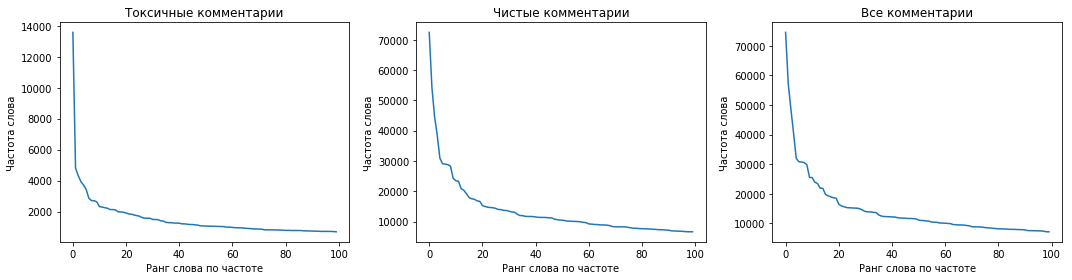

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, (fdist, title) in enumerate(zip(fdists, titles)):
    ax[i].plot(sorted(fdist.values(), reverse=True)[:100])
    ax[i].set(xlabel='Ранг слова по частоте', ylabel='Частота слова', title=title + ' комментарии')

plt.tight_layout()

### Биграммы и триграммы

In [41]:
for n, name in zip([2, 3], ['Биграммы', 'Триграммы']):
    for is_clear, title in enumerate(['токсичные', 'чистые']):
        all_ngrams = []

        for index_, words_list in train_df[train_df['clear'] == is_clear]['comment_words'].iteritems():
            all_ngrams.extend((list(ngrams(words_list, n))))

        print('{} - {} комментарии:'.format(name, title))
        print(pd.Series(all_ngrams).value_counts()[:10])
        print('\n')

/Users/nikolay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: generator 'ngrams' raised StopIteration
  


Биграммы - токсичные комментарии:
(fuck, fuck)        2471
(nigger, nigger)    2019
(hate, hate)        1571
(moron, hi)         1474
(hi, moron)         1472
(faggot, faggot)    1380
(pig, pig)          1251
(jew, fat)          1234
(fat, jew)          1226
(go, fuck)          1186
dtype: int64


Биграммы - чистые комментарии:
(talk, page)            14826
(speedy, deletion)       4402
(fair, use)              3238
(reliable, source)       3146
(block, edit)            2535
(personal, attack)       2510
(edit, war)              2400
(wikipedia, article)     2355
(feel, free)             2311
(talk, contribs)         2219
dtype: int64


Триграммы - токсичные комментарии:
(fuck, fuck, fuck)          2290
(nigger, nigger, nigger)    2008
(hate, hate, hate)          1547
(hi, moron, hi)             1468
(moron, hi, moron)          1466
(faggot, faggot, faggot)    1372
(pig, pig, pig)             1248
(fat, jew, fat)             1226
(jew, fat, jew)             1224
(suck, suck, suck)     

In [42]:
for n, name in zip([2, 3], ['Биграммы', 'Триграммы']):
    all_ngrams = []

    for index_, words_list in train_df['comment_words'].iteritems():
        all_ngrams.extend((list(ngrams(words_list, n))))

    print(name + ' - все комментарии:')
    print(pd.Series(all_ngrams).value_counts()[:10])
    print('\n')

/Users/nikolay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


Биграммы - все комментарии:
(talk, page)            15636
(speedy, deletion)       4421
(fair, use)              3269
(reliable, source)       3239
(personal, attack)       2831
(block, edit)            2594
(edit, war)              2495
(fuck, fuck)             2471
(wikipedia, article)     2409
(feel, free)             2359
dtype: int64


Триграммы - все комментарии:
(fuck, fuck, fuck)               2290
(en, wikipedia, org)             2016
(nigger, nigger, nigger)         2009
(wikipedia, org, wiki)           1584
(hate, hate, hate)               1548
(hi, moron, hi)                  1468
(moron, hi, moron)               1466
(criterion, speedy, deletion)    1454
(article, talk, page)            1451
(faggot, faggot, faggot)         1372
dtype: int64




# Облако слов

Соединим каждый из списков в отдельную строку.

In [44]:
toxic_text = ' '.join(words_from_toxic_comments)
clear_text = ' '.join(words_from_clear_comments)

Зададим параметры для построения облака слов.

In [45]:
cloud_params = {
    'max_words': 200,
    'regexp': '[a-z]+',
    'collocations': False,
    
    'width': 2400,
    'height': 1200,
    'margin': 5,
    
    'relative_scaling': 1,
    'prefer_horizontal': 1,
    'min_font_size': 20,
    'font_step': 2,
 
    'background_color': None,
    'mode': 'RGBA',
    
    'random_state': 42
}

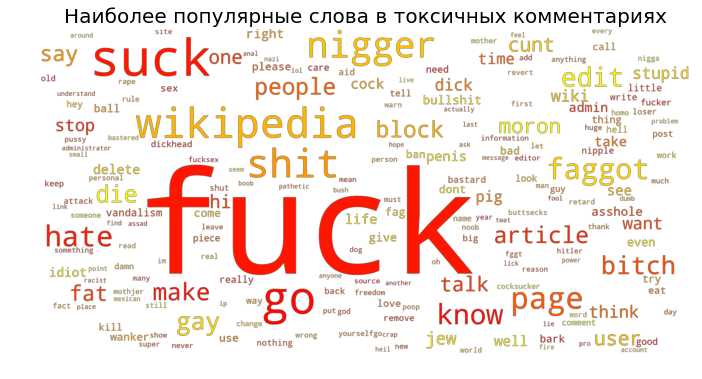

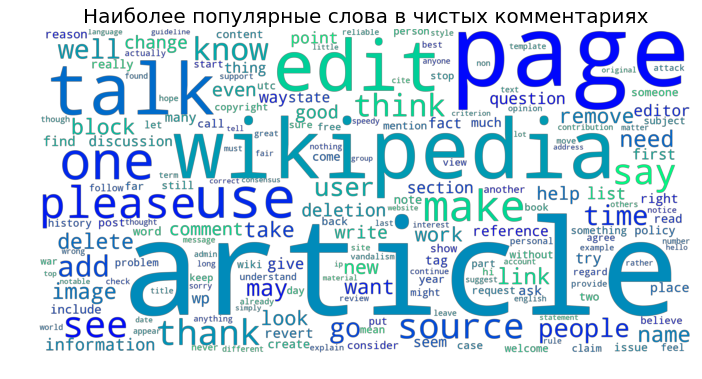

In [46]:
texts = [toxic_text, clear_text]
cmaps = ['autumn', 'winter']
titles = ['токсичных', 'чистых']

for text, cmap, title in zip(texts, cmaps, titles):
    word_cloud = WordCloud(colormap=cmap, **cloud_params)
    word_cloud.generate(text)
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.title('Наиболее популярные слова в {} комментариях'.format(title), fontsize=20)
    plt.imshow(word_cloud, interpolation='bilinear')
#     plt.imsave(title + '.png', word_cloud)

# Построение модели

Создадим функцию для объединения слов каждого комментария в отдельную строку.

In [47]:
def comment_words_to_str(list_of_words):
    return ' '.join(list_of_words)

In [48]:
train_df['comment_words_str'] = train_df['comment_words'].apply(comment_words_to_str)
test_df['comment_words_str'] = test_df['comment_words'].apply(comment_words_to_str)

In [196]:
all_comments = pd.concat([train_df['comment_words_str'], test_df['comment_words_str']], axis=0)
all_comments.shape

(312735,)

In [197]:
def min_df_tuning(min_df_values):
    
    # словарь, в котором для каждого значения min_df указаны максимальное значением ROC AUC и
    # оптимальные параметраы логистической регрессии для всех классов токсичных комментариев
    params_score_dict = dict()
    
    for min_df in min_df_values:
        word_vectorizer = TfidfVectorizer(analyzer='word',
                                          stop_words=None,
                                          lowercase=False,
                                          token_pattern="[a-z]+",
                                          max_features=None,
                                          min_df=min_df,
                                          max_df=1.0)

        all_words = word_vectorizer.fit_transform(all_comments)
        train_words = all_words[:len(train_df)]
        test_words = all_words[len(train_df):]
        print('min df: {}, количество признаков: {}, обработано столбцов: '.format(min_df, all_words.shape[1]), end='')

        log_reg = LogisticRegression(random_state=42)
        
        # словарь, в котором для конкретного значения min_df указаны максимальное значением ROC AUC и
        # оптимальные параметраы логистической регрессии для всех классов токсичных комментариев
        params_score_dict[min_df] = dict()

        for i, tox_type in enumerate(train_df.columns[2:8], start=1):
            train_target = train_df[tox_type]

            param_grid = {'penalty': ['l1', 'l2'],
                          'C': np.logspace(-4, 1, 6)}

            grid_search = GridSearchCV(log_reg, param_grid=param_grid, scoring='roc_auc', cv=3)
            grid_search.fit(train_words, train_target)

            params_score_dict[min_df][tox_type] = (grid_search.best_score_, grid_search.best_params_)
            print(i, end=' ')
        print()
    
    return params_score_dict

Запуск TfidfVectorizer с параметром max_df=0.25 дал то же количество признаков, что и запуск с параметром max_df=1.0. Значит, каждое слово встречаются в менее, чем 25% всех документов.

In [198]:
def plot_min_df_tuning(params_score_dict):
    scores = [np.mean([val[0] for val in value.values()]) for value in params_score_dict.values()]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(params_score_dict.keys(), scores)
    ax.set(title='Настройка min_df в TfidfVectorizer', xlabel='Значение min_df',
                                           ylabel='Среднее значение ROC AUC по 6 столбцам')

### Поиск параметров - 1

In [199]:
params_score_dict = min_df_tuning([2 ** i for i in range(0, 11, 1)])

min df: 1, количество признаков: 264994, обработано столбцов: 1 2 3 4 5 6 
min df: 2, количество признаков: 93256, обработано столбцов: 1 2 3 4 5 6 
min df: 4, количество признаков: 49610, обработано столбцов: 1 2 3 4 5 6 
min df: 8, количество признаков: 29929, обработано столбцов: 1 2 3 4 5 6 
min df: 16, количество признаков: 19177, обработано столбцов: 1 2 3 4 5 6 
min df: 32, количество признаков: 12521, обработано столбцов: 1 2 3 4 5 6 
min df: 64, количество признаков: 8167, обработано столбцов: 1 2 3 4 5 6 
min df: 128, количество признаков: 5333, обработано столбцов: 1 2 3 4 5 6 
min df: 256, количество признаков: 3370, обработано столбцов: 1 2 3 4 5 6 
min df: 512, количество признаков: 2083, обработано столбцов: 1 2 3 4 5 6 
min df: 1024, количество признаков: 1233, обработано столбцов: 1 2 3 4 5 6 


In [200]:
params_score_dict[1]

{'identity_hate': (0.97512604985609908, {'C': 1.0, 'penalty': 'l2'}),
 'insult': (0.97407513872883866, {'C': 1.0, 'penalty': 'l2'}),
 'obscene': (0.98150516325775805, {'C': 1.0, 'penalty': 'l2'}),
 'severe_toxic': (0.98442424731722933, {'C': 1.0, 'penalty': 'l2'}),
 'threat': (0.97936129892590063, {'C': 1.0, 'penalty': 'l2'}),
 'toxic': (0.96738034581765198, {'C': 1.0, 'penalty': 'l2'})}

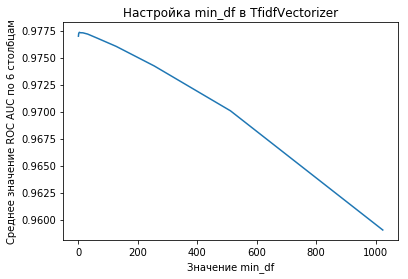

In [201]:
plot_min_df_tuning(params_score_dict)

### Поиск параметров - 2

In [202]:
params_score_dict = min_df_tuning(range(0, 52, 3))

min df: 0, количество признаков: 264994, обработано столбцов: 1 2 3 4 5 6 
min df: 3, количество признаков: 62985, обработано столбцов: 1 2 3 4 5 6 
min df: 6, количество признаков: 36589, обработано столбцов: 1 2 3 4 5 6 
min df: 9, количество признаков: 27685, обработано столбцов: 1 2 3 4 5 6 
min df: 12, количество признаков: 23047, обработано столбцов: 1 2 3 4 5 6 
min df: 15, количество признаков: 20021, обработано столбцов: 1 2 3 4 5 6 
min df: 18, количество признаков: 17819, обработано столбцов: 1 2 3 4 5 6 
min df: 21, количество признаков: 16225, обработано столбцов: 1 2 3 4 5 6 
min df: 24, количество признаков: 14961, обработано столбцов: 1 2 3 4 5 6 
min df: 27, количество признаков: 13881, обработано столбцов: 1 2 3 4 5 6 
min df: 30, количество признаков: 13014, обработано столбцов: 1 2 3 4 5 6 
min df: 33, количество признаков: 12271, обработано столбцов: 1 2 3 4 5 6 
min df: 36, количество признаков: 11675, обработано столбцов: 1 2 3 4 5 6 
min df: 39, количество призн

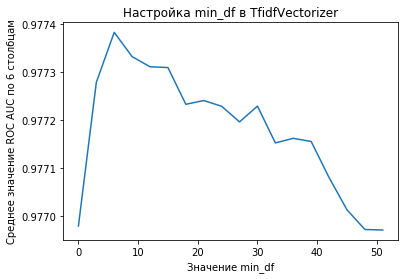

In [203]:
plot_min_df_tuning(params_score_dict)

In [220]:
scores = [np.mean([val[0] for val in value.values()]) for value in params_score_dict.values()]
print('Значение, дающее наилучшее качество алгоритма: min_df =', list(params_score_dict.keys())[np.argmax(scores)])

Значение, дающее наилучшее качество алгоритма: min_df = 6


In [222]:
params_score_dict[6]

{'identity_hate': (0.9751648210582825, {'C': 1.0, 'penalty': 'l2'}),
 'insult': (0.97462479949078651, {'C': 1.0, 'penalty': 'l2'}),
 'obscene': (0.98164718091801295, {'C': 1.0, 'penalty': 'l2'}),
 'severe_toxic': (0.98493045691242032, {'C': 1.0, 'penalty': 'l2'}),
 'threat': (0.97971346985215935, {'C': 1.0, 'penalty': 'l2'}),
 'toxic': (0.96821349479020291, {'C': 1.0, 'penalty': 'l2'})}

Оптимальные параметры логистической регрессии для всех 6 столбцов: C=1, penalty='l2'

### Построение модели с оптимальными параметрами

In [223]:
word_vectorizer = TfidfVectorizer(analyzer='word',
                                  stop_words=None,
                                  lowercase=False,
                                  token_pattern="[a-z]+",
                                  max_features=None,
                                  min_df=6,
                                  max_df=1.0)

all_words = word_vectorizer.fit_transform(all_comments)
train_words = all_words[:len(train_df)]
test_words = all_words[len(train_df):]

submission = pd.DataFrame.from_dict({'id': test_df['id']})
log_reg = LogisticRegression(C=1, penalty='l2', random_state=42)

In [224]:
for tox_type in train_df.columns[2:8]:
    train_target = train_df[tox_type]
    log_reg.fit(train_words, train_target)
    submission[tox_type] = log_reg.predict_proba(test_words)[:, 1]

In [225]:
submission.to_csv('submission.csv', index=False)

### Среднее значение ROC AUC по 6 столбцам на Kaggle:  0.9751